In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
import pandas as pd
import numpy as np
import os

import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import layers, Input
from keras.layers import InputLayer, MaxPooling2D, Flatten, Dense, Conv2D, Dropout
from keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from tensorflow.keras.optimizers import Adam, SGD

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from PIL.Image import open

from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
import random
%matplotlib inline

In [7]:
# Constants
IMAGE_DATASET = "../input/brain-tumor/Brain Tumor/Brain Tumor"
IMAGE_DATASET_RAW = r"..\input\brain-tumor\Brain Tumor\Brain Tumor"
WORKING_FOLDER = "/kaggle/working"
IMG_HEIGHT = 224
IMG_WIDTH = 224
EPOCHS = 50

In [8]:
# # Image3202
# plt.figure(figsize=(20,20))
# test_folder="../input/brain-tumor/Brain Tumor/Brain Tumor/Image3202.jpg" 
# img=mpimg.imread(test_folder)
# print(img.size)
# ax=plt.subplot(1,5,i+1)
# # ax.title.set_text(file)
# plt.imshow(img)

In [9]:
# We will import the csv file containing the features and the classes of the images
cortex_df = pd.read_csv("../input/brain-tumor/Brain Tumor.csv")
cortex_df.head()

,Image,Class,Mean,Variance,Standard Deviation,Entropy,Skewness,Kurtosis,Contrast,Energy,ASM,Homogeneity,Dissimilarity,Correlation,Coarseness
0,Image1,0,6.535339,619.587845,24.891522,0.109059,4.276477,18.900575,98.613971,0.293314,0.086033,0.530941,4.473346,0.981939,7.458341e-155
1,Image2,0,8.749969,805.957634,28.389393,0.266538,3.718116,14.464618,63.858816,0.475051,0.225674,0.651352,3.220072,0.988834,7.458341e-155
2,Image3,1,7.341095,1143.808219,33.820234,0.001467,5.061750,26.479563,81.867206,0.031917,0.001019,0.268275,5.981800,0.978014,7.458341e-155
3,Image4,1,5.958145,959.711985,30.979219,0.001477,5.677977,33.428845,151.229741,0.032024,0.001026,0.243851,7.700919,0.964189,7.458341e-155
4,Image5,0,7.315231,729.540579,27.010009,0.146761,4.283221,19.079108,174.988756,0.343849,0.118232,0.501140,6.834689,0.972789,7.458341e-155


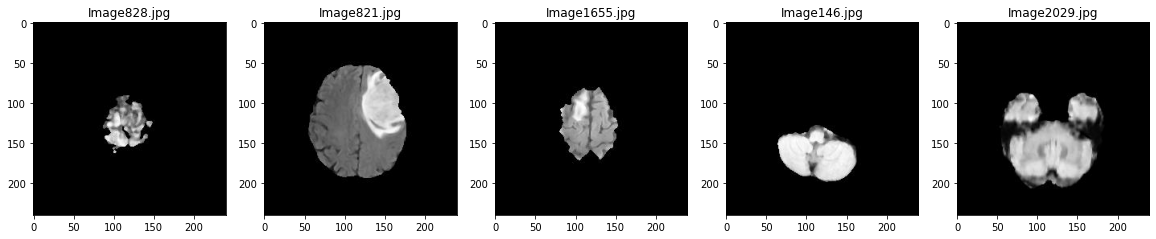

In [10]:
plt.figure(figsize=(20,20))
test_folder="../input/brain-tumor/Brain Tumor/Brain Tumor" 
for i in range(5):
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

In [11]:
dataset_df = pd.DataFrame()
dataset_df["Image"] = cortex_df["Image"]
dataset_df["Class"] = cortex_df["Class"]
path_list = []
for img_path in os.listdir(IMAGE_DATASET):
    path_list.append( os.path.join(IMAGE_DATASET,img_path))
path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in path_list}
dataset_df["paths"] = cortex_df["Image"].map(path_dict.get)
dataset_df["pixels"] = dataset_df["paths"].map(lambda x:np.asarray(open(x).resize((IMG_HEIGHT,IMG_WIDTH))))
dataset_df.head()

,Image,Class,paths,pixels
0,Image1,0,../input/brain-tumor/Brain Tumor/Brain Tumor/I...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,Image2,0,../input/brain-tumor/Brain Tumor/Brain Tumor/I...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,Image3,1,../input/brain-tumor/Brain Tumor/Brain Tumor/I...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,Image4,1,../input/brain-tumor/Brain Tumor/Brain Tumor/I...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,Image5,0,../input/brain-tumor/Brain Tumor/Brain Tumor/I...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [16]:
image_list = []
for i in range(len(dataset_df)):
    brain_image = dataset_df["pixels"][i].astype(np.float32)
    brain_image /= 255
    image_list.append(brain_image)
X = np.array(image_list)
print(X.shape)

(3762, 224, 224, 3)


In [17]:
y = np.array(dataset_df.Class)
y.shape

(3762,)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('The shape of the X_train :'+' '+str(X_train.shape))
print('The size of the X_train :'+' '+str(X_train.shape[0]))
print('The shape of the X_test :'+' '+str(X_test.shape))
print('The size of the X_test:'+' '+str(X_test.shape[0]))

The shape of the X_train : (3009, 224, 224, 3)
The size of the X_train : 3009
The shape of the X_test : (753, 224, 224, 3)
The size of the X_test: 753


In [19]:
def model(input_shape):
#     res_conv = ResNet50(include_top=False, weights="imagenet", input_tensor=None, input_shape=input_shape, pooling=None)
    model = Sequential()
    
    model.add(Input(shape=input_shape))
    
    model.add(Conv2D(16, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(Conv2D(16, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last", padding='same'))
            
    model.add(Conv2D(32, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(Conv2D(32, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last", padding='same'))
    
    model.add(Conv2D(64, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(Conv2D(64, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last", padding='same'))
    
#     model.add(Conv2D(128, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
#     model.add(Conv2D(128, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
#     model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last", padding='same'))
    
#     model.add(Conv2D(256, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
#     model.add(Conv2D(256, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
#     model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last", padding='same'))
    
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dense(128, activation="relu"))
#     model.add(Dropout(0.4))
    model.add(Dense(1, activation="sigmoid"))    # Never use sigmoid for binary classification
    
    return model

In [20]:
model = model(input_shape = (IMG_HEIGHT, IMG_WIDTH, 3))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 64)          1

In [22]:
# optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name="Adam",)
optimizer = SGD(learning_rate=0.01)
loss_fn = BinaryCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

In [23]:
# Training the model
history = model.fit(x=X_train, y=y_train, epochs=EPOCHS, batch_size=10)

Epoch 1/50
301/301 [==============================] - 7s 8ms/step - loss: 0.6147 - accuracy: 0.6679
Epoch 2/50
301/301 [==============================] - 2s 8ms/step - loss: 0.5029 - accuracy: 0.7608
Epoch 3/50
301/301 [==============================] - 2s 8ms/step - loss: 0.4484 - accuracy: 0.7886
Epoch 4/50
301/301 [==============================] - 2s 8ms/step - loss: 0.4098 - accuracy: 0.8150
Epoch 5/50
301/301 [==============================] - 2s 8ms/step - loss: 0.3636 - accuracy: 0.8400
Epoch 6/50
301/301 [==============================] - 2s 8ms/step - loss: 0.3299 - accuracy: 0.8596
Epoch 7/50
301/301 [==============================] - 2s 8ms/step - loss: 0.3109 - accuracy: 0.8599
Epoch 8/50
301/301 [==============================] - 3s 9ms/step - loss: 0.2654 - accuracy: 0.8850
Epoch 9/50
301/301 [==============================] - 2s 8ms/step - loss: 0.2751 - accuracy: 0.8766
Epoch 10/50
301/301 [==============================] - 2s 8ms/step - loss: 0.2194 - accuracy: 0.9167

In [24]:
model.save("BrainTumorv7")

In [25]:
# Creating a zip of the model folder 
!tar -zcvf BrainTumorv7.tar.gz /kaggle/working/BrainTumorv7

tar: Removing leading `/' from member names
/kaggle/working/BrainTumorv7/
/kaggle/working/BrainTumorv7/assets/
/kaggle/working/BrainTumorv7/variables/
/kaggle/working/BrainTumorv7/variables/variables.index
/kaggle/working/BrainTumorv7/variables/variables.data-00000-of-00001
/kaggle/working/BrainTumorv7/saved_model.pb


In [27]:
loss = history.history["loss"]
acc = history.history["accuracy"]

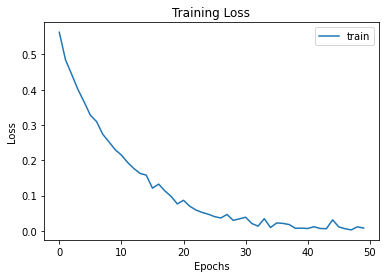

In [28]:
epoch = np.arange(EPOCHS)
plt.plot(epoch, loss)
# plt.plot(epoch, val_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend(['train', 'val'])

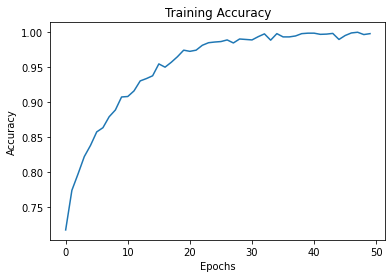

In [29]:
epoch = np.arange(EPOCHS)
plt.plot(epoch, acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy');

In [26]:
eval_score = model.evaluate(X_test, y_test)
print("Test loss:", eval_score[0])
print("Test accuracy:", eval_score[1])

24/24 [==============================] - 1s 16ms/step - loss: 0.3102 - accuracy: 0.9177
Test loss: 0.31020626425743103
Test accuracy: 0.9176626801490784


In [30]:
y_pred = model.predict_classes(X_test)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [33]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
y_pred.shape

(753, 1)

In [35]:
from sklearn.metrics import confusion_matrix , classification_report
target_classes = ['No Tumor','Tumor']
classification_report(y_test , y_pred , output_dict = True
                      , target_names=target_classes)

{'No Tumor': {'precision': 0.9432624113475178,
  'recall': 0.973170731707317,
  'f1-score': 0.957983193277311,
  'support': 410},
 'Tumor': {'precision': 0.9666666666666667,
  'recall': 0.9300291545189504,
  'f1-score': 0.9479940564635958,
  'support': 343},
 'accuracy': 0.953519256308101,
 'macro avg': {'precision': 0.9549645390070922,
  'recall': 0.9515999431131337,
  'f1-score': 0.9529886248704533,
  'support': 753},
 'weighted avg': {'precision': 0.9539233138368512,
  'recall': 0.953519256308101,
  'f1-score': 0.9534330286994833,
  'support': 753}}

In [36]:
confusion_matrix(y_test , y_pred ) 

array([[399,  11],
       [ 24, 319]])